In [1]:
# imports
import meshplot as mp
import matplotlib.pyplot as plt
import nibabel as nb
import numpy as np
import igl_testing
from ipywidgets import interactive, fixed, FloatSlider
import ipywidgets as widgets
from IPython.display import Javascript, display

In [2]:
# define metrics for comparing operators
def squared_difference(x, y):
    return np.square(x - y)

def percentage_difference(x, y):
    return (y-x / y) * 100

def abs_percentage_difference(x, y):
    return np.abs((x-y / y) * 100)

def get_differences(metric, y, x1, x2):
    # calculate differences
    diff_lbo, diff_gl = [metric(curv, y) for curv in (x1, x2)]
    # get summary stats
    mean_diff_lbo, mean_diff_gl = [diff.mean() for diff in (diff_lbo, diff_gl)]
    std_diff_lbo, std_diff_gl = [diff.std() for diff in (diff_lbo, diff_gl)]
    return (diff_lbo, mean_diff_lbo, std_diff_lbo), (diff_gl, mean_diff_gl, std_diff_gl)

def plot_differences(v, f, analytic, lbo_curv, gl_curv, metric):
    # get differences and summary stats
    lbo_diffs, gl_diffs = get_differences(metric, analytic, lbo_curv, gl_curv)
    # get viewing range
    clip_val = lbo_diffs[1] + lbo_diffs[2]
    lbo_clipped_diff, gl_clipped_diff = [np.clip(diffs[0], -clip_val, clip_val) for diffs in (lbo_diffs, gl_diffs)]
    # plot
    if metric == squared_difference:
        print("Squared difference")
    elif metric == percentage_difference:
        print("Percentage difference")
    diff_plots = mp.subplot(v, f, c=lbo_clipped_diff, s=[1, 2, 0])
    mp.subplot(v, f, c=gl_clipped_diff, s=[1, 2, 1], data=diff_plots)
    pass

In [3]:
# load surface
surface_name = '/home/ibmeuser/Documents/Data/hcp-asl/HCP_asl_min_req_mean_16_onsurface/HCA6002236/T1w/fsaverage_LR32k/HCA6002236_V1_MR.L.midthickness.32k_fs_LR.surf.gii'
surface = nb.load(surface_name)
v, f = surface.agg_data()

# evaluate lbo and gl operators
lbo = igl_testing.testing_igl.get_lbo(v, f, area_type='voronoi')
gl = igl_testing.testing_igl.get_graph_laplacian(f)

/home/ibmeuser/anaconda3/envs/igl/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [4]:
def eval_func(surface_name, func, s):
    surface = nb.load(surface_name)
    v, f = surface.agg_data()
    # evaluate function and curvature
    u = igl_testing.functions.FUNCS[func](v, s)
    an_curv = igl_testing.curvatures.CURVS[func](v, s)
    curv_min, curv_max = [an_curv.min(), an_curv.max()]
    print(f"Min curvature = {curv_min:0.2f}. Max curvature = {curv_max:0.2f}")
    # plot
    tab = "                          "
    print(f"{tab}Function {tab}Analytic curvature")
    data = mp.subplot(v, f, c=u, s=[1, 2, 0])
    mp.subplot(v, f, c=an_curv, s=[1, 2, 1], data=data)
    return u, an_curv, curv_min, curv_max

def display_clipped(surface_name, an_curv, lbo_u, gl_u, display_range):
    # load surface
    surface = nb.load(surface_name)
    v, f = surface.agg_data()
    # clip values
    curv_max = display_range
    curv_min = - curv_max
    clipped_lbo_u, clipped_gl_u = [np.clip(curv, curv_min, curv_max) for curv in (lbo_u, gl_u)]
    # plot the 3 curvatures for comparison
    tab = "            "
    print(f"{tab}Analytic curvature {2*tab}LBO curvature {2*tab}GL curvature")
    curv_plots = mp.subplot(v, f, c=an_curv, s=[1, 3, 0])
    mp.subplot(v, f, c=clipped_lbo_u, s=[1, 3, 1], data=curv_plots)
    mp.subplot(v, f, c=clipped_gl_u, s=[1, 3, 2], data=curv_plots)
    
    return curv_min, curv_max

def run_below_on_change(change):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))

In [5]:
# evaluate function at each vertex
functions = [*igl_testing.functions.FUNCS.keys()]
function_plot = interactive(
    eval_func,
    surface_name=fixed(surface_name),
    func=widgets.Dropdown(options=functions, description='Function'),
    s=FloatSlider(min=0.1, max=1.5, step=0.1, value=0.75, continuous_update=False, description='Speed')
)
output = function_plot.children[-1]
output.layout.height='450px'
display(function_plot)


interactive(children=(Dropdown(description='Function', options=('sumsincosxy', 'sumsincosxz', 'sumsincosyz'), …

In [6]:
function_plot.children[0].observe(run_below_on_change)
function_plot.children[1].observe(run_below_on_change)
# make widgets out of curv_min so when it changes we recalculate lbo_u
u, an_curv, curv_min, curv_max = function_plot.result

# get curvature via the LBO and the graph laplacian
lbo_u = lbo.dot(u)
gl_u = gl.dot(u)

# plot
curve_plot = interactive(
    display_clipped,
    surface_name=fixed(surface_name),
    an_curv=fixed(an_curv),
    lbo_u=fixed(lbo_u),
    gl_u=fixed(gl_u),
    display_range=widgets.FloatSlider(min=0.0, max=curv_max*10, step=0.1, value=curv_max, continuous_update=False, description='Clip range')
)
curve_out = curve_plot.children[-1]
curve_out.layout.height = '450px'
display(curve_plot)

interactive(children=(FloatSlider(value=1.124820590019226, continuous_update=False, description='Clip range', …

In [7]:
# get differences and summary statistics
(lbo_sq_err, lbo_mean_sq_err, lbo_std_sq_err), (gl_sq_err, gl_mean_sq_err, gl_std_sq_err) = get_differences(squared_difference, an_curv, lbo_u, gl_u)
(lbo_perc_err, lbo_mean_perc_err, lbo_std_perc_err), (gl_perc_err, gl_mean_perc_err, gl_std_perc_err) = get_differences(percentage_difference, an_curv, lbo_u, gl_u)
# threshold the difference to be able to compare between plots (which automatically noramlise individual subplots)
# sq_max = lbo_mean_sq_err + lbo_std_sq_err
sq_max = np.abs(an_curv.max())
perc_max = 50
# lbo
lbo_clipped_sq_err = np.clip(lbo_sq_err, 0, sq_max)
lbo_clipped_perc_err = np.clip(lbo_perc_err, -perc_max, perc_max)
# gl
gl_clipped_sq_err = np.clip(gl_sq_err, 0, sq_max)
gl_clipped_perc_err = np.clip(gl_perc_err, -perc_max, perc_max)
# plot differences
print("Squared difference plots")
sq_diff_plots = mp.subplot(v, f, c=lbo_clipped_sq_err, s=[1, 2, 0])
mp.subplot(v, f, c=gl_clipped_sq_err, s=[1, 2, 1], data=sq_diff_plots)
print("Percentage difference plots")
perc_diff_plots = mp.subplot(v, f, c=lbo_clipped_perc_err, s=[1, 2, 0])
mp.subplot(v, f, c=gl_clipped_perc_err, s=[1, 2, 1], data=perc_diff_plots)

Squared difference plots


Percentage difference plots


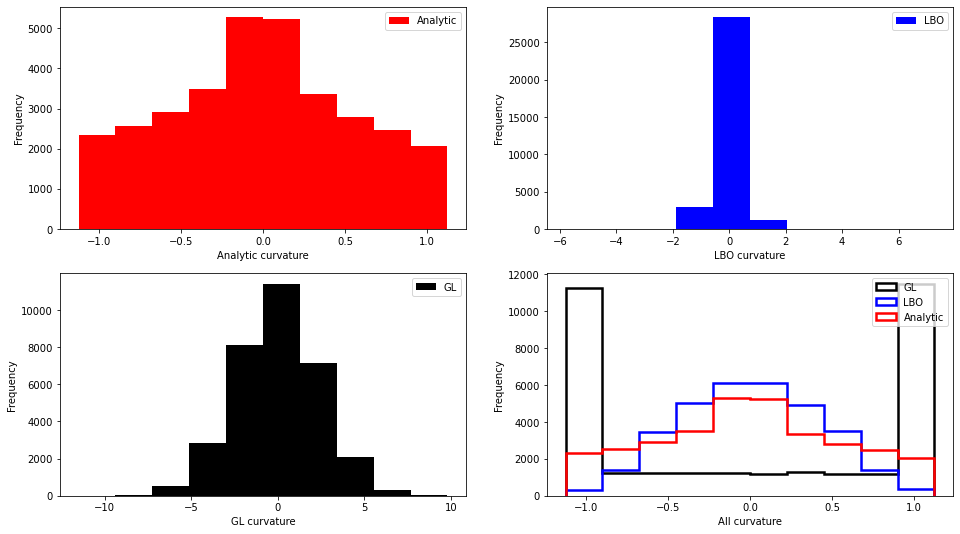

In [8]:
# show histograms of raw values
curv_min, curv_max = curve_plot.result
clipped_lbo_u, clipped_gl_u = [np.clip(curv, curv_min, curv_max) for curv in (lbo_u, gl_u)]
nbins = 10
colours = ('r', 'b', 'k')
labels = ('Analytic', 'LBO', 'GL', 'All')
fig, axs = plt.subplots(2, 2, figsize=(16, 9))
for ax, label, curv, colour in zip(axs.reshape(-1,), 
                                   labels, 
                                   (an_curv, lbo_u, gl_u, (an_curv, clipped_lbo_u, clipped_gl_u)), 
                                   (*colours, colours)):
    if label == 'All':
        ax.hist(curv, nbins, color=colour, label=labels, histtype='step', stacked=False, fill=False, linewidth=2.5)
    else:
        ax.hist(curv, nbins, color=colour, label=label)
    ax.set_xlabel(f"{label} curvature")
    ax.set_ylabel("Frequency")
    ax.legend()

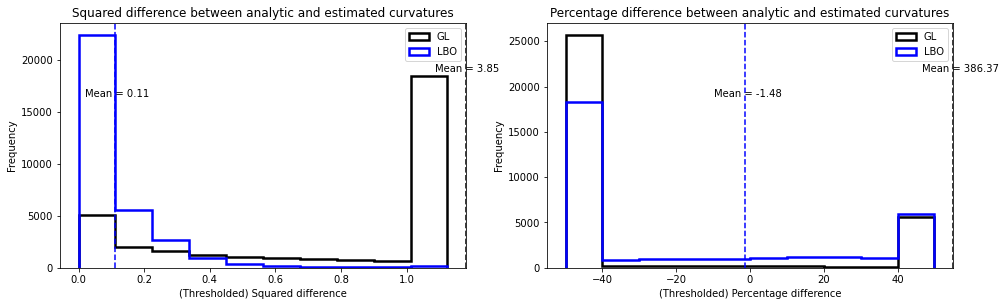

In [9]:
# show histograms of metrics
nbins = 10
perc_offset = 7.5
colours = ('b', 'k')
labels = ('LBO', 'GL')
metrics = ('Squared difference', 'Percentage difference')
metric_diffs = (
    (lbo_clipped_sq_err, gl_clipped_sq_err),
    (lbo_clipped_perc_err, gl_clipped_perc_err)
)
summary_stats = (
    (lbo_mean_sq_err, gl_mean_sq_err),
    (lbo_mean_perc_err, gl_mean_perc_err)
)
y_offs = (0.7, 0.8)
fig, axs = plt.subplots(1, 2, figsize=(16, 4.5))
for ax, metric, diffs, summary in zip(axs, metrics, metric_diffs, summary_stats):
    # unpacking
    diff_lbo, diff_gl = diffs
    texts = [f"Mean = {sum_stat:.2f}" for sum_stat in summary]
    # plot
    ax.hist((diff_lbo, diff_gl), nbins, color=colours, label=labels, histtype='step', stacked=False, fill=False, linewidth=2.5)
    x_range = ax.get_xlim()
    offset = (perc_offset / 100) * (x_range[1] - x_range[0])
    # print summary statistics
    for sum_stat, colour, text, y_off in zip(summary, colours, texts, y_offs):
        # check if sum_stat is in axis range
        in_range = np.logical_and(sum_stat>x_range[0], sum_stat<x_range[1])
        if not in_range:
            if sum_stat < x_range[0]:
                x_pos = x_range[0]
                txt_pos = x_pos + offset
            else:
                x_pos = x_range[1]
                txt_pos = x_pos - offset
        else:
            x_pos = sum_stat
            txt_pos = x_pos - offset
        ax.axvline(x_pos, color=colour, linestyle="--")
        ax.annotate(text, xy=(txt_pos, y_off*ax.get_ylim()[1]), xycoords='data')
    ax.set_xlabel(f"(Thresholded) {metric}")
    ax.set_ylabel("Frequency")
    ax.set_title(f"{metric} between analytic and estimated curvatures")
    ax.legend(loc=1)